In [1]:
# Install all required libraries
!pip install googlemaps pillow pandas openpyxl requests matplotlib seaborn scikit-learn tensorflow grad-cam -q

import pandas as pd
import numpy as np
import requests
import os
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries installed successfully!")


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ All libraries installed successfully!


In [4]:
# CELL 2 (FIXED): Upload CSV Files
print("📁 Upload your train CSV file first")
uploaded = files.upload()

# Load train file
train_file = list(uploaded.keys())[0]
train_df = pd.read_csv(train_file)

print(f"\n✅ Train loaded: {train_df.shape}")
print(f"📊 Train columns: {list(train_df.columns)}")

# Now upload test file
print("\n📁 Now upload your test CSV file")
uploaded_test = files.upload()

# Load test file
test_file = list(uploaded_test.keys())[0]
test_df = pd.read_csv(test_file)

print(f"\n✅ Test loaded: {test_df.shape}")
print(f"📊 Test columns: {list(test_df.columns)}")

# Display stats
print(f"\n🎯 Target variable (price) stats:")
if 'price' in train_df.columns:
    print(train_df['price'].describe())
else:
    print("Available columns:", list(train_df.columns))

print("\n📋 First 5 rows of training data:")
train_df.head()


📁 Upload your train CSV file first


Saving train(1)(train(1)).csv to train(1)(train(1)) (2).csv

✅ Train loaded: (16209, 21)
📊 Train columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

📁 Now upload your test CSV file


Saving test2(test(1)).csv to test2(test(1)).csv

✅ Test loaded: (5404, 20)
📊 Test columns: ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

🎯 Target variable (price) stats:
count    1.620900e+04
mean     5.374703e+05
std      3.603036e+05
min      7.500000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64

📋 First 5 rows of training data:


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [7]:
# CELL 3: Sentinel Hub Authentication (SECURE)
print("🛰️ Sentinel Hub Setup")
print("Get credentials from: https://apps.sentinel-hub.com/dashboard/#/account/settings")
print("\n1. Sign up at https://www.sentinel-hub.com/")
print("2. Go to Dashboard > User Settings > OAuth clients")
print("3. Create OAuth client and copy credentials\n")

# Use getpass to hide input (won't show on screen or in notebook output)
from getpass import getpass

CLIENT_ID = getpass("Enter your Client ID (hidden): ")
CLIENT_SECRET = getpass("Enter your Client Secret (hidden): ")

# Install sentinelhub package
!pip install sentinelhub -q

from sentinelhub import SHConfig

# Configure
config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET
config.save()

# Clear variables from memory for extra security
import gc
CLIENT_ID = None
CLIENT_SECRET = None
gc.collect()

print("\n✅ Sentinel Hub configured successfully!")
print("⚠️ Credentials are stored securely and not visible in notebook output")


🛰️ Sentinel Hub Setup
Get credentials from: https://apps.sentinel-hub.com/dashboard/#/account/settings

1. Sign up at https://www.sentinel-hub.com/
2. Go to Dashboard > User Settings > OAuth clients
3. Create OAuth client and copy credentials

Enter your Client ID (hidden): ··········
Enter your Client Secret (hidden): ··········
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.7 MB/s eta 0:00:00

✅ Sentinel Hub configured successfully!
⚠️ Credentials are stored securely and not visible in notebook output


In [8]:
# CELL 4: Sentinel Hub Image Fetcher
from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    bbox_to_dimensions,
)
from datetime import datetime, timedelta

def fetch_satellite_image_sentinel(lat, lon, config, output_dir="images"):
    """Fetch high-res satellite image using Sentinel Hub"""
    os.makedirs(output_dir, exist_ok=True)

    # Define bounding box around the property (roughly 200m x 200m)
    coords_wgs84 = [lon - 0.001, lat - 0.001, lon + 0.001, lat + 0.001]
    bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=60)

    # Cap at 400x400
    if size[0] > 400 or size[1] > 400:
        size = (400, 400)

    # Evalscript for true color imagery
    evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: ["B04", "B03", "B02"],
            output: { bands: 3 }
        };
    }
    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
    """

    try:
        # Request from last 6 months
        time_interval = (datetime.now() - timedelta(days=180), datetime.now())

        request = SentinelHubRequest(
            evalscript=evalscript,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_interval,
                    maxcc=0.3,
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=bbox,
            size=size,
            config=config,
        )

        img_list = request.get_data()

        if img_list and len(img_list) > 0:
            img_array = img_list[0]
            img = Image.fromarray(img_array)
            img = img.resize((400, 400), Image.LANCZOS)
            return np.array(img)
        else:
            return None

    except Exception as e:
        print(f"Error: {e}")
        return None

def download_all_images_sentinel(df, config, dataset_name="train", output_dir="images"):
    """Download satellite images using Sentinel Hub"""
    success_count = 0
    failed_ids = []

    os.makedirs(output_dir, exist_ok=True)

    print(f"\n🛰️ Downloading {len(df)} Sentinel-2 images for {dataset_name} dataset...")

    for idx, row in df.iterrows():
        property_id = row['id'] if 'id' in df.columns else idx
        lat = row['lat']
        lon = row['long']

        img_array = fetch_satellite_image_sentinel(lat, lon, config, output_dir=output_dir)

        if img_array is not None:
            img = Image.fromarray(img_array)
            img.save(f"{output_dir}/{dataset_name}_{property_id}.jpg")
            success_count += 1

            if (idx + 1) % 10 == 0:
                print(f"✓ Downloaded {idx + 1}/{len(df)} images...")
        else:
            failed_ids.append(property_id)

        import time
        time.sleep(0.2)

    print(f"\n✅ Successfully downloaded: {success_count}/{len(df)} images")
    if failed_ids:
        print(f"❌ Failed IDs: {failed_ids[:10]}...")

    return success_count, failed_ids

print("✅ Sentinel Hub image fetcher ready!")


✅ Sentinel Hub image fetcher ready!


🚀 Starting Sentinel-2 download...


🛰️ Downloading 30 Sentinel-2 images for train dataset...
✓ Downloaded 10/30 images...
✓ Downloaded 20/30 images...
✓ Downloaded 30/30 images...

✅ Successfully downloaded: 30/30 images

🛰️ Downloading 10 Sentinel-2 images for test dataset...
✓ Downloaded 10/10 images...

✅ Successfully downloaded: 10/10 images

🎉 Download complete!
Train: 30 images | Test: 10 images


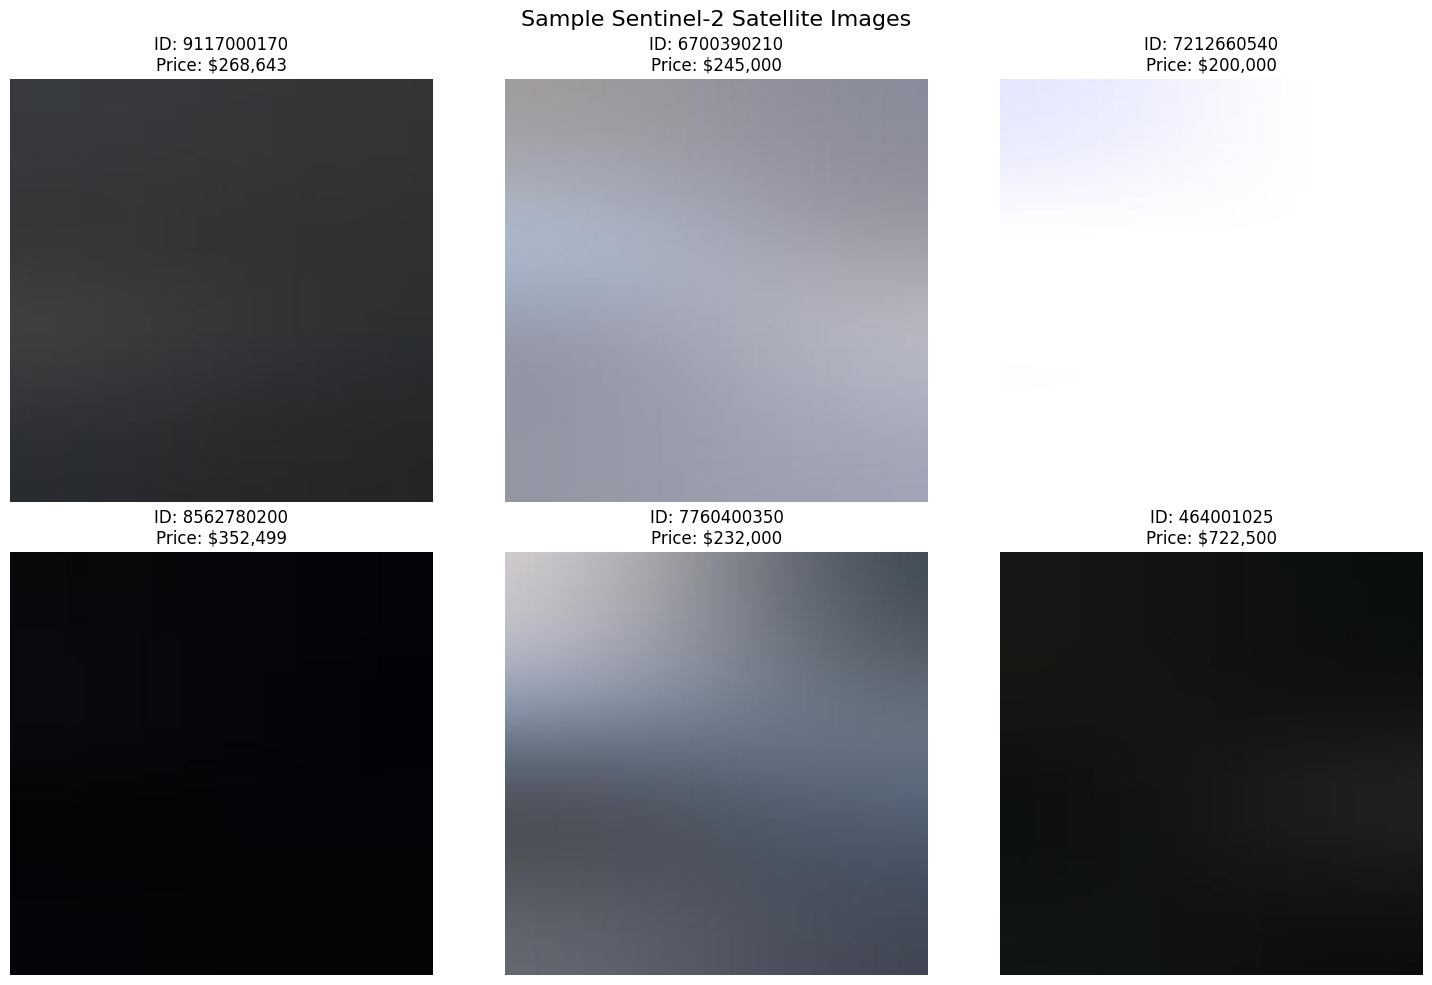


✅ Ready for EDA and modeling!


In [9]:
# CELL 5: Download Images
print("🚀 Starting Sentinel-2 download...\n")

config = SHConfig()

# Test with first 30 images (remove .head(30) for full dataset)
train_subset = train_df.head(30)
train_success, train_failed = download_all_images_sentinel(
    train_subset,
    config,
    dataset_name="train",
    output_dir="images"
)

# Test images
test_subset = test_df.head(10)
test_success, test_failed = download_all_images_sentinel(
    test_subset,
    config,
    dataset_name="test",
    output_dir="images"
)

print(f"\n🎉 Download complete!")
print(f"Train: {train_success} images | Test: {test_success} images")

# Display samples
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sample Sentinel-2 Satellite Images', fontsize=16)

for i in range(min(6, len(train_subset))):
    property_id = train_subset['id'].iloc[i] if 'id' in train_subset.columns else i
    img_path = f"images/train_{property_id}.jpg"

    if os.path.exists(img_path):
        img = Image.open(img_path)
        ax = axes[i//3, i%3]
        ax.imshow(img)
        price = train_subset['price'].iloc[i] if 'price' in train_subset.columns else 'N/A'
        ax.set_title(f"ID: {property_id}\nPrice: ${price:,.0f}" if price != 'N/A' else f"ID: {property_id}")
        ax.axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Ready for EDA and modeling!")


EXPLORATORY DATA ANALYSIS

📊 Dataset Overview:
Training samples: 16209
Test samples: 5404

Missing values in train:
Series([], dtype: int64)


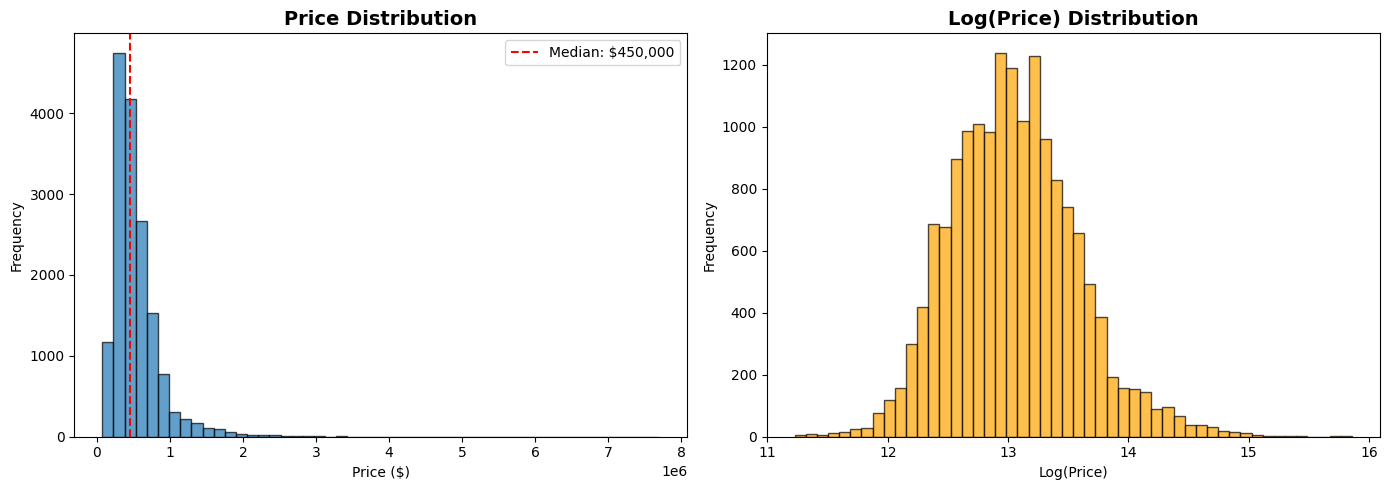


💰 Price Statistics:
count    1.620900e+04
mean     5.374703e+05
std      3.603036e+05
min      7.500000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64

Skewness: 4.03

🔧 Creating Engineered Features...
✅ Engineered features created!
New feature count: 25

📈 Top 10 Features Correlated with Price:
price             1.000000
sqft_living       0.700933
luxury_score      0.681391
grade             0.664266
sqft_above        0.602648
sqft_living15     0.581781
price_per_sqft    0.551471
bathrooms         0.525487
view              0.390534
sqft_basement     0.320301
lat               0.310008
Name: price, dtype: float64


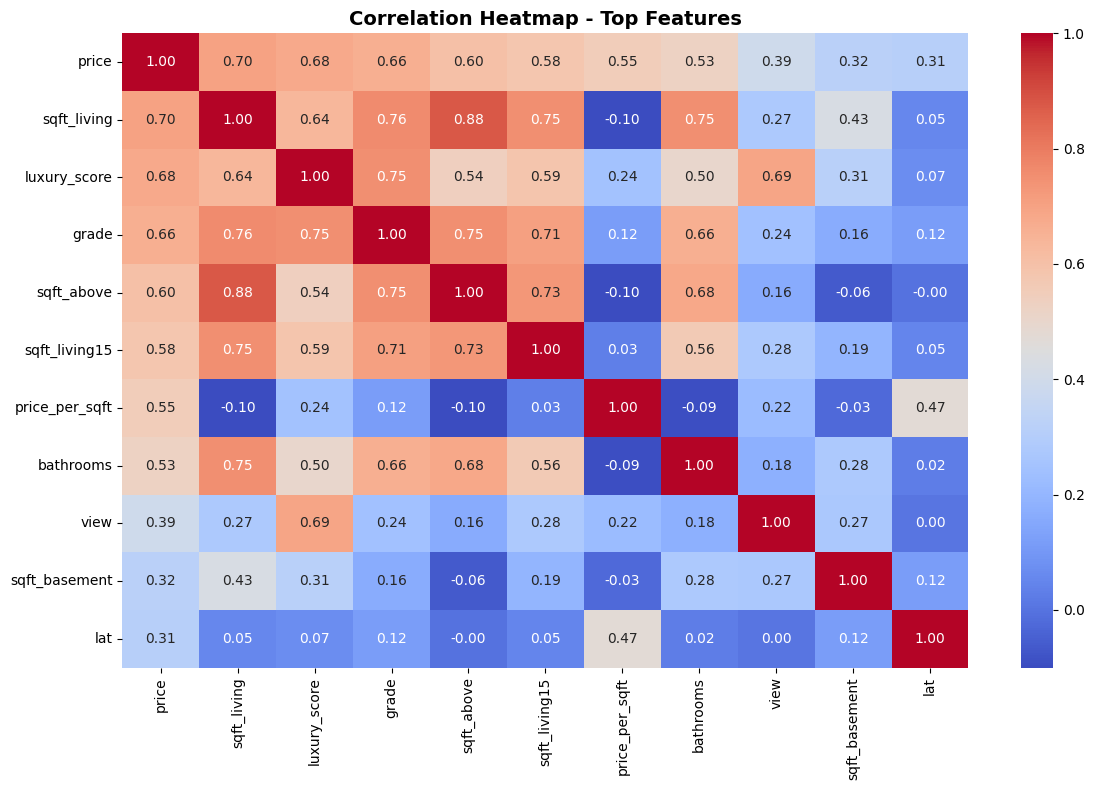


🗺️ Geospatial Price Distribution:


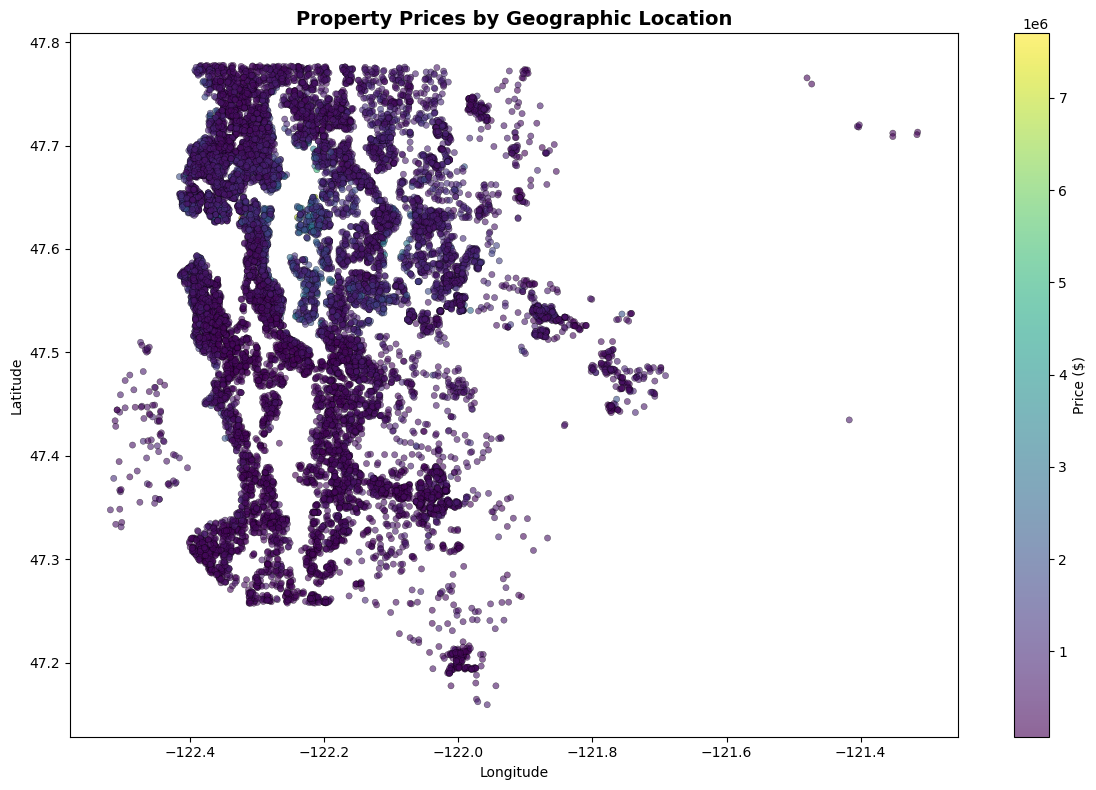


✅ EDA Complete! Ready for modeling...


In [10]:
# CELL 6: Exploratory Data Analysis & Feature Engineering
import seaborn as sns
from scipy import stats

print("=" * 60)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# 1. Basic Statistics
print("\n📊 Dataset Overview:")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nMissing values in train:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

# 2. Target Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price distribution
axes[0].hist(train_df['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Price Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(train_df['price'].median(), color='red', linestyle='--', label=f"Median: ${train_df['price'].median():,.0f}")
axes[0].legend()

# Log-transformed price (more normal)
axes[1].hist(np.log1p(train_df['price']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Log(Price) Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\n💰 Price Statistics:")
print(train_df['price'].describe())
print(f"\nSkewness: {stats.skew(train_df['price']):.2f}")

# 3. Feature Engineering
print("\n🔧 Creating Engineered Features...")

def engineer_features(df):
    """Create new features from existing ones"""
    df = df.copy()

    # Price per sqft
    df['price_per_sqft'] = df['price'] / df['sqft_living'] if 'price' in df.columns else None

    # Lot ratio (how much of the lot is house vs land)
    df['lot_ratio'] = df['sqft_living'] / df['sqft_lot']

    # Basement indicator
    df['has_basement'] = (df['sqft_basement'] > 0).astype(int)

    # Luxury score (grade + condition + view + waterfront)
    df['luxury_score'] = df['grade'] + df['condition'] + df['view'] + (df['waterfront'] * 3)

    # Neighbor premium (how house compares to neighbors)
    df['neighbor_living_premium'] = df['sqft_living'] / df['sqft_living15']
    df['neighbor_lot_premium'] = df['sqft_lot'] / df['sqft_lot15']

    # Age-related (if yr_built and yr_renovated exist)
    if 'yr_built' in df.columns:
        df['age'] = 2026 - df['yr_built']
        if 'yr_renovated' in df.columns:
            df['renovated'] = (df['yr_renovated'] > 0).astype(int)
            df['years_since_renovation'] = 2026 - df['yr_renovated']
            df['years_since_renovation'] = df['years_since_renovation'].replace(2026, 0)

    return df

train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

print(f"✅ Engineered features created!")
print(f"New feature count: {len([c for c in train_df.columns if c not in ['id', 'price', 'date', 'lat', 'long']])}")

# 4. Correlation Analysis
print("\n📈 Top 10 Features Correlated with Price:")
if 'price' in train_df.columns:
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    correlations = train_df[numeric_cols].corr()['price'].sort_values(ascending=False)
    print(correlations.head(11))  # Top 10 + price itself

    # Heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    top_features = correlations.head(11).index
    sns.heatmap(train_df[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
    plt.title('Correlation Heatmap - Top Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 5. Geospatial Visualization
print("\n🗺️ Geospatial Price Distribution:")
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(train_df['long'], train_df['lat'],
                     c=train_df['price'], s=20, alpha=0.6,
                     cmap='viridis', edgecolors='black', linewidth=0.3)
plt.colorbar(scatter, ax=ax, label='Price ($)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Property Prices by Geographic Location', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ EDA Complete! Ready for modeling...")


In [11]:
# CELL 7: Data Preparation for Multimodal Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("=" * 60)
print("PREPARING MULTIMODAL DATASET")
print("=" * 60)

# 1. Select features for tabular model
feature_cols = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
    'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
    'lot_ratio', 'has_basement', 'luxury_score',
    'neighbor_living_premium', 'neighbor_lot_premium'
]

# Add age features if available
if 'age' in train_df.columns:
    feature_cols.extend(['age', 'renovated', 'years_since_renovation'])

# Filter only available columns
feature_cols = [c for c in feature_cols if c in train_df.columns]

print(f"\n📋 Using {len(feature_cols)} tabular features:")
print(feature_cols)

# 2. Prepare tabular data
X_tabular = train_df[feature_cols].fillna(0).values
y = train_df['price'].values

X_test_tabular = test_df[feature_cols].fillna(0).values

# Scale features
scaler = StandardScaler()
X_tabular_scaled = scaler.fit_transform(X_tabular)
X_test_tabular_scaled = scaler.transform(X_test_tabular)

# Train/val split
X_train_tab, X_val_tab, y_train, y_val = train_test_split(
    X_tabular_scaled, y, test_size=0.2, random_state=42
)

print(f"\n✅ Tabular data prepared:")
print(f"   Train: {X_train_tab.shape}")
print(f"   Val: {X_val_tab.shape}")
print(f"   Test: {X_test_tabular_scaled.shape}")

# 3. Prepare image data loader
def load_and_preprocess_image(image_path):
    """Load and preprocess a single image"""
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])  # ResNet input size
        img = tf.keras.applications.resnet50.preprocess_input(img)
        return img
    except:
        # Return blank image if file doesn't exist
        return tf.zeros([224, 224, 3])

def create_image_dataset(df, dataset_name="train", batch_size=32):
    """Create TensorFlow dataset for images"""
    image_paths = []
    indices = []

    for idx, row in df.iterrows():
        property_id = row['id'] if 'id' in df.columns else idx
        img_path = f"images/{dataset_name}_{property_id}.jpg"
        if os.path.exists(img_path):
            image_paths.append(img_path)
            indices.append(idx)

    print(f"Found {len(image_paths)} images for {dataset_name} dataset")

    # Load images
    images = []
    for path in image_paths:
        img = load_and_preprocess_image(path)
        images.append(img.numpy())

    return np.array(images), indices

# Load images (use subset for speed)
print("\n🖼️ Loading satellite images...")
X_train_img, train_img_indices = create_image_dataset(train_df.head(30), "train")
X_test_img, test_img_indices = create_image_dataset(test_df.head(10), "test")

# Match tabular data to images
X_train_tab_matched = X_train_tab[:len(X_train_img)]
y_train_matched = y_train[:len(X_train_img)]

print(f"\n✅ Image data prepared:")
print(f"   Train images: {X_train_img.shape}")
print(f"   Test images: {X_test_img.shape}")

print("\n🚀 Ready to build multimodal model!")


PREPARING MULTIMODAL DATASET

📋 Using 21 tabular features:
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'lot_ratio', 'has_basement', 'luxury_score', 'neighbor_living_premium', 'neighbor_lot_premium', 'age', 'renovated', 'years_since_renovation']

✅ Tabular data prepared:
   Train: (12967, 21)
   Val: (3242, 21)
   Test: (5404, 21)

🖼️ Loading satellite images...
Found 30 images for train dataset
Found 10 images for test dataset

✅ Image data prepared:
   Train images: (30, 224, 224, 3)
   Test images: (10, 224, 224, 3)

🚀 Ready to build multimodal model!
